# How to set up your computer to use [Altair](https://altair-viz.github.io/index.html) with Qubole data

## Essential Steps

### 1. Install Python3
Check if you have python3 installed by running in your shell (mac Terminal or Windows Command Prompt):

```
python3 --version
```

If you do not have Python 3 installed and are on a mac then follow [these instructions](https://wsvincent.com/install-python3-mac/) to install Python3 using the homebrew package manager. 

On Windows, you can download Python [here](https://www.python.org/downloads/). Make sure the *Add Python 3.X to Path* tick-box is checked during installation.

### 2. Create a Python3 virtual environment called *pydatavis* and activate it

If you haven't created a virtual environment before, try the helpful [instructions here](https://wsvincent.com/install-python3-mac/) (same steps for macOS and Windows) to create and activate a virtual environment, using the venv package that ships with python3.

### 3. Install Altair, JupyterLab, Pandas and the Qubole Python SDK in the *pydatavis* virtual environment

With the pydatavis virtual environment activated in the shell, run:

```
pip install -U altair vega_datasets jupyterlab pandas qds-sdk
```

The [qds-sdk](https://github.com/qubole/qds-sdk-py) module from Qubole will allow us to use the Qubole API to request data.

You can check at any time which packages and package versions have been installed by running:

```
pip list
```

Verify that the installed jupyterlab version is *at least* V1.0

### 4. Check that you can pull data from an HCOM Qubole Account

Now that you have JupyterLabs installed you can work with Jupyter notebooks such as this one that you're reading now. Clone or download [this repository](https://github.com/wongsuwarn/haxDataVis) from Github and navigate to the folder in your shell. Then run:

```
jupyter lab setup_instructions.ipynb
```

The JupyterLab environment will open a new page in your browser and you will see this notebook. JupyterLab has started a server on your machine that is hosting your local copy of this notebook. You can tell when you are hosting the page locally as you will see the browser address as something like *localhost:XXXX*.

From now on follow the instructions in the notebook that is running on your local server.

Create a connector class by running the following cell (Shift+Enter):

In [30]:
import os
import re
import pandas as pd
from qds_sdk.commands import HiveCommand
from qds_sdk.qubole import Qubole

class QuboleConnector():
    def __init__(self, hcom_api_token, bex_api_token):
        pass

    def query_data(self, sql_query, account):
        if account == 'hcom':
            Qubole.configure(api_token=hcom_api_token)
        else:
            Qubole.configure(api_token=bex_api_token)
                
        cmd = self.execute_query(sql_query)

        if HiveCommand.is_success(cmd.status):
            with open("temp_data.csv", 'w') as writer:
                if account == 'hcom':
                    cmd.get_results(writer, delim=",", inline=False)
                else:
                    cmd.get_results(writer, delim="\t", inline=False)

            clean_query = sql_query.replace('\n', '')
            clean_query = re.sub("\\([^)]*?\\)", "", clean_query)
            heads = re.search('select(.*?)from', clean_query.lower()).group(1).split(',')
            heads = [h.strip() for h in heads]
            heads = [h if ' as ' not in h else re.search(' as (.*)', h).group(1) for h in heads]      
        
            if account == 'hcom':
                query_result = pd.read_csv("temp_data.csv", names = heads)
            else:
                query_result = pd.read_csv("temp_data.csv", names = heads, sep='\t')
        os.remove("temp_data.csv")
        return query_result

    def execute_query(self, sql_query):
        hc_params = ['--query', sql_query]
        hive_args = HiveCommand.parse(hc_params)
        cmd = HiveCommand.run(**hive_args)
        return cmd

Set your Qubole API token(s) which can be found [here](https://api.qubole.com/v2/control-panel#manage-accounts) in the next cell.

In [32]:
my_hcom_api_token='[INSERT-HCOM-TOKEN-HERE]'
my_bex_api_token='[INSERT-HCOM-TOKEN-HERE]' # Set as empty string if you don't have one

# simon's tokens (let him know if you need to use)
# hcom_api_token='e430f9db5ff2473897c52d834f4a65742cdddcadbb43409e8684b7309d26e194'
# bex_api_token='4ddc9f9d5bfd452ab0aaca49625af6082d6f016e57c04cbe8abd64002ed346af'
# hcom_api_token=''
# bex_api_token=''

Instatiate a new Qubole connector object with your token(s):

In [36]:
hcom_con = QuboleConnector(hcom_api_token = my_hcom_api_token, bex_api_token = my_bex_api_token)

# create a separate bex connector object if needed
# bex_con = QuboleConnector(bex_api_token) 

Store this example SQL query as the string variable hcom_data_sample_query: 

In [34]:
hcom_data_sample_query = """
SELECT 
    booking_gross_profit_amt_usd
    ,omniture_gross_booking_value_usd
FROM bix_clickstream.hermes_omniture_booking_order_summary
WHERE omniture_local_date = '2019-05-01'

LIMIT 1000
"""

Send the query to Qubole using the connector object and assign the API result to a local pandas dataframe called hcom_data_sample_df:

In [22]:
# below we pass 'hcom' argument to account parameter of query_data function
hcom_data_sample_df = hcom_con.query_data(hcom_data_sample_query, account = 'hcom')

Run the following cell to preview the first 5 rows of the dataframe. If you see some rows of booking data then the Qubole connector is working correctly to pull HCOM data.

In [16]:
hcom_data_sample_df.head()

,booking_gross_profit_amt_usd,omniture_gross_booking_value_usd
0,17.3993,100.6800
1,38.5086,478.3800
2,5.5155,55.4500
3,3.8093,118.9669
4,9.883,80.8935


### 5. Check that you can render the data with Altair

Run the following cell. If it returns a scatter plot then you're now ready to create data visualisations with [Altair](https://altair-viz.github.io/index.html) in a Jupyter notebook.

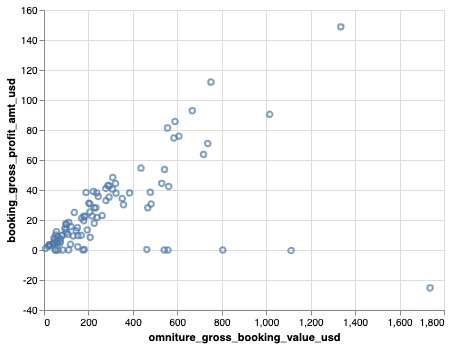

In [19]:
import altair as alt

alt.Chart(hcom_data_sample_df).mark_point().encode(
    x = 'omniture_gross_booking_value_usd',
    y = 'booking_gross_profit_amt_usd'
)

## Optional Steps

### Check if you can pull data from a BEX Qubole Account

Set your BEX API token, which can be found [here](https://api.qubole.com/v2/control-panel#manage-accounts).

In [ ]:
bex_api_token='4ddc9f9d5bfd452ab0aaca49625af6082d6f016e57c04cbe8abd64002ed346af'

Launch a test query on a table in the BEX Qubole account:

In [ ]:
bex_data_sample_query = """
SELECT 
    expe_property_id
    ,hcom_property_id
    ,super_region_name
FROM dm.property
WHERE hcom_property_id IS NOT NULL

LIMIT 1000
"""

# below we pass 'bex' argument to account parameter of query_data function
bex_data_sample_df = bex_con.query_data(sql_query=bex_data_sample_query, account='bex') 

Run the following cell to preview the first 5 rows of the dataframe. If you see some rows of booking data then the Qubole connector is working correctly to pull BEX data.

In [ ]:
bex_data_sample_df.head()